In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
mean102=np.load("102dots_ds_mean_std.npy")
mean128=np.load("128dots_ds_mean_std.npy")
mean153=np.load("153dots_ds_mean_std.npy")
mean179=np.load("179dots_ds_mean_std.npy")

In [7]:
300*153/256

179.296875

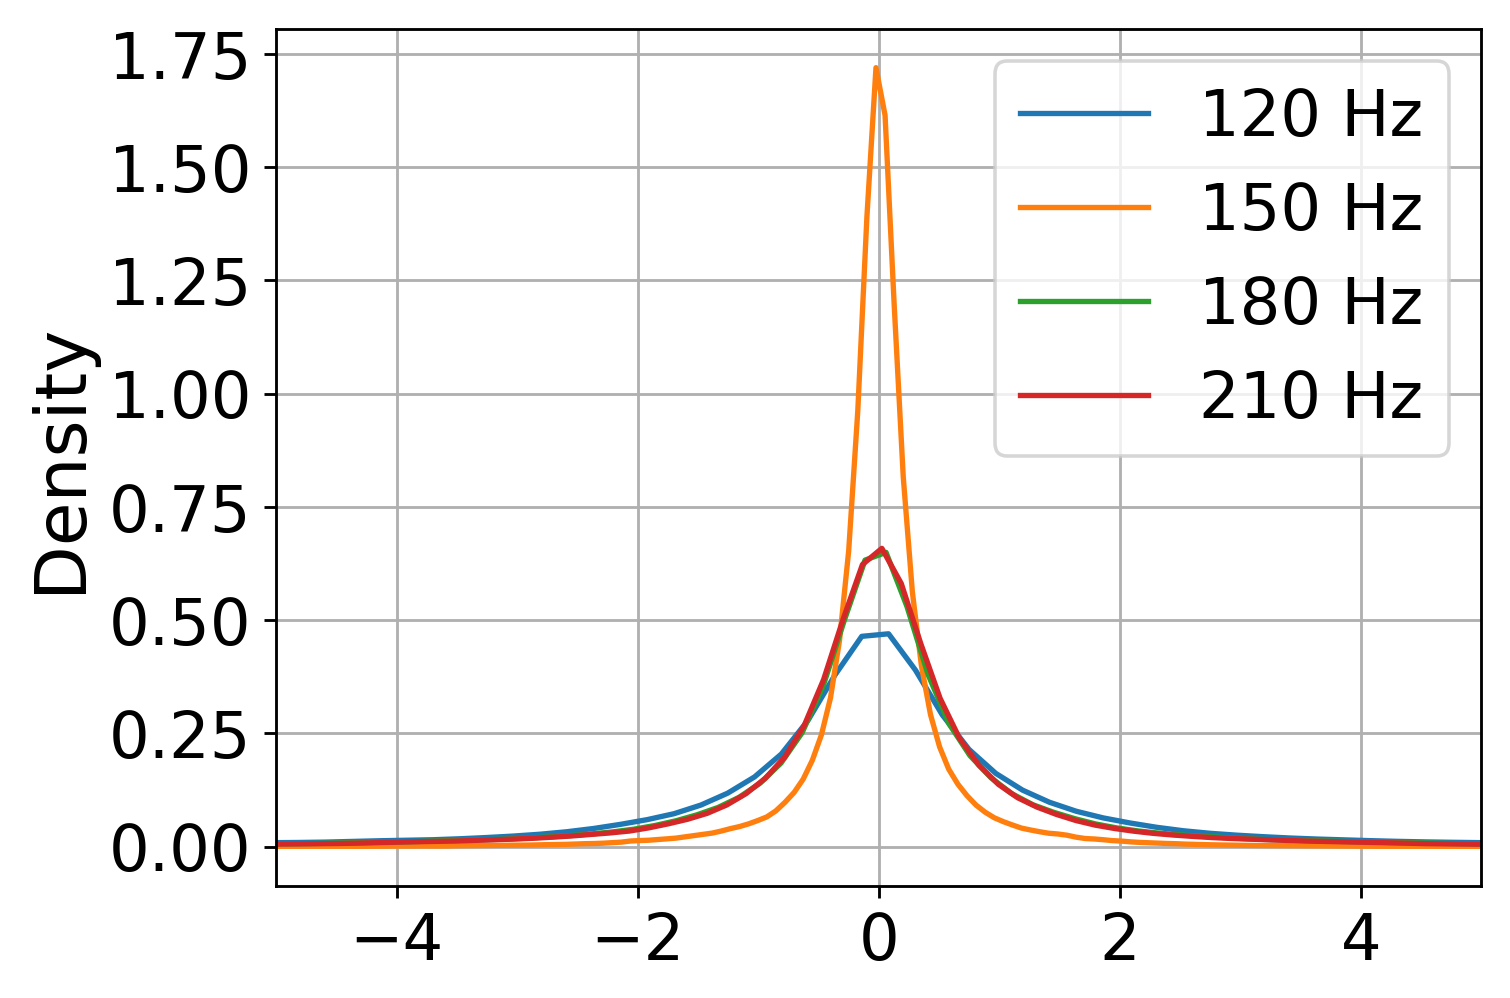

In [141]:
fig=plt.figure(dpi=256)

ax = fig.add_subplot(111)

pd.Series(mean102[:,0]).plot.kde()
pd.Series(mean128[:,0]).plot.kde()
pd.Series(mean153[:,0]).plot.kde()
pd.Series(mean179[:,0]).plot.kde()
plt.xlim([-5,5])
#plt.title("Kde of Mean of Residual Sequence")
plt.legend(['120 Hz','150 Hz','180 Hz','210 Hz'],fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
ax.set_ylabel("Density",fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig("Kde_of_Mean")
plt.show()

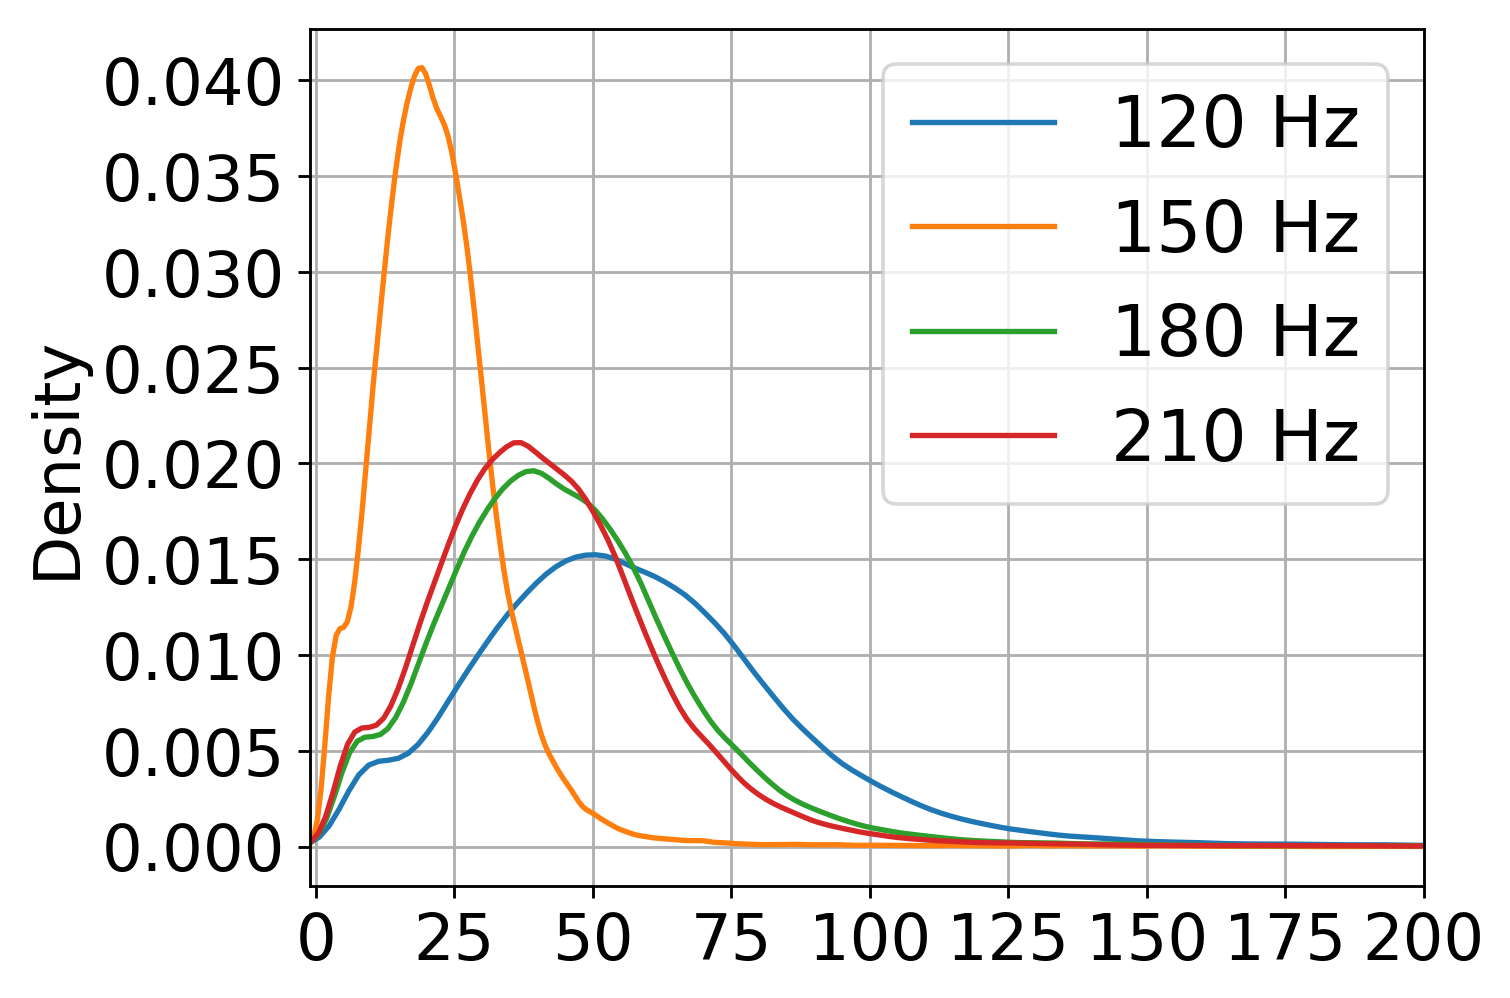

In [138]:
fig=plt.figure(dpi=256)

ax = fig.add_subplot(111)
pd.Series(mean102[:,1]).plot.kde(fontsize=18)
pd.Series(mean128[:,1]).plot.kde()
pd.Series(mean153[:,1]).plot.kde()
pd.Series(mean179[:,1]).plot.kde()

plt.legend(['120 Hz','150 Hz','180 Hz','210 Hz'],fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
ax.set_ylabel("Density",fontsize=18)
plt.xlim([-1,200])
plt.grid()
#plt.title("Kde of Std of Residual Sequence")
plt.tight_layout()
plt.savefig("Kde_of_Std")
plt.show()

In [130]:
?plt.set_yaxis()

Object `plt.set_yaxis` not found.


In [83]:
# coding=utf-8

# 解析CHE
import time
import numpy as np
import matplotlib.pyplot as plt


class ParseCHE:
    # noinspection PyInterpreter
    def __init__(self):
        self.__spo2Rs__ = []
        self.__resp2List__ = []
        self.__respList__ = []
        self.__ecgList__ = []
        self.__xList__ = []
        self.__yList__ = []
        self.__zList__ = []
        self.__spo2Val__ = []
        self.__time__=[]

    def __parseSpo2Val__(self, _byte):
        """
        解析血氧值
        :param _byte:
        :return:
        """
        spo2Val = _byte & 0xff
        self.__spo2Val__.append(spo2Val)

    def __parseEcg__(self, ecg):
        """
        解析心电波形
        :param ecg:
        :return:
        """
        ecg = bytearray(ecg)
        for group in range(0, 4):
            for i in range(0, 50):
                m = int(i / 4)
                n = i % 4
                b = ecg[group * 63 + m]
                kk = 0
                if n == 0:
                    kk = b & 0x03
                elif n == 1:
                    kk = (b & 0x0c) >> 2
                elif n == 2:
                    kk = (b & 0x30) >> 4
                elif n == 3:
                    kk = (b & 0xc0) >> 6
                byteLow = ecg[group * 63 + 13 + i]
                int_result = ((kk & 0xff) << 8) | (byteLow & 0xff)
                self.__ecgList__.append(int_result)

    def __parseResp__(self, resp):
        """
        解析胸呼吸波形
        :param resp:
        :return:
        """
        for i in range(0, int(len(resp) / 2)):
            dataH = resp[i * 2] & 0xff
            dataL = resp[i * 2 + 1] & 0xff
            rs = dataH << 8 | dataL
            rs = int(rs)
            self.__respList__.append(rs)

    def __parseResp2__(self, resp2):
        """
        解析腹呼吸波形
        :param resp2:
        :return:
        """
        for i in range(0, int(len(resp2) / 2)):
            dataH = resp2[i * 2] & 0xff
            dataL = resp2[i * 2 + 1] & 0xff
            rs = dataH << 8 | dataL
            rs = int(rs)
            self.__resp2List__.append(rs)

    def __parseMovement__(self, movement):
        """
        解析体动信息
        :param movement:
        :return:
        """
        x_start0 = 0
        y_start0 = 32
        z_start0 = 64
        x_start = 7
        y_start = 7 * 2 + 25
        z_start = 7 * 3 + 25 * 2
        for i in range(0, 25):
            m = int(i / 4)
            n = i % 4
            b_x = movement[x_start0 + m]
            b_y = movement[y_start0 + m]
            b_z = movement[z_start0 + m]
            xx = 0;
            yy = 0;
            zz = 0
            if n == 0:
                xx = b_x & 0x03
                yy = b_y & 0x03
                zz = b_z & 0x03
            elif n == 1:
                xx = (b_x & 0x0c) >> 2;
                yy = (b_y & 0x0c) >> 2;
                zz = (b_z & 0x0c) >> 2;
            elif n == 2:
                xx = (b_x & 0x30) >> 4;
                yy = (b_y & 0x30) >> 4;
                zz = (b_z & 0x30) >> 4;
            elif n == 3:
                xx = (b_x & 0xc0) >> 6;
                yy = (b_y & 0xc0) >> 6;
                zz = (b_z & 0xc0) >> 6;

            x = (xx & 0xff) << 8 | movement[x_start + i] & 0xff
            y = (yy & 0xff) << 8 | movement[y_start + i] & 0xff
            z = (zz & 0xff) << 8 | movement[z_start + i] & 0xff
            x, y, z = int(x), int(y), int(z)
            self.__xList__.append(x)
            self.__yList__.append(y)
            self.__zList__.append(z)

    def __parseSop2__(self, spo2):
        for i in range(0, len(spo2)):
            num = spo2[i] & 0x7f;
            self.__spo2Rs__.append(num)

    def parse(self, filePath):
        """
        :param filePath: 要解析的che文件绝对路径
        :return: ecgList,respList,resp2List,xList,yList,zList
        """
        f = open(filePath, 'rb')
        while True:
            temp = f.read(576)
            if len(temp) == 0:
                break
            else:
                data = temp[:521]
                resp = data[7:7 + 50]
                resp2 = data[57:57 + 50]
                ecg = data[107:107 + 4 * 63]
                movement = data[7 + 50 * 2 + 63 * 4:7 + 50 * 2 + 63 * 4 + 96]
                spo2 = data[7 + 50 * 2 + 63 * 4 + 96:7 + 50 * 2 + 63 * 4 + 96 + 50]
                spo2_v = data[7 + 50 * 2 + 63 * 4 + 96 + 50 + 9]
                time0 = data[3]
                time1 = data[4]
                time2 = data[5]
                time3 = data[6]
                time = (time0 & 0xff) << 24 | (time1 & 0xff) << 16 | (time2 & 0xff) << 8 | (time3 & 0xff)
                self.__time__.append(time)

                self.__parseEcg__(ecg)
                self.__parseResp__(resp)
                self.__parseResp2__(resp2)
                self.__parseMovement__(movement)
                self.__parseSop2__(spo2)
                self.__parseSpo2Val__(spo2_v)
        self.dict = {
            'ecgList': self.__ecgList__,
            'respList': self.__respList__,
            'resp2List': self.__resp2List__,
            'xList': self.__xList__,
            'yList': self.__yList__,
            'zList': self.__zList__,
            'spo2ValList': self.__spo2Val__,
            'time': self.__time__,
            'spo2List': self.__spo2Rs__

        }
        return self.dict


In [84]:
#0000013D-2018_05_08-18_20_31.CHE.che
filepath = r'0000013D-2018_05_08-18_20_31.CHE.che'

cl = ParseCHE()
data = cl.parse(filepath)
ecg = data['ecgList']
resp_ch = data['respList']
resp_ab = data['resp2List']
spo_calue = data['spo2ValList']
xList = data['xList']
yList = data['yList']
zList = data['zList']
time_st = data['time']

In [88]:
import scipy.io as matio

Physionetdata=matio.loadmat('./training2017/'+'A00021'+'.mat')['val'][0]
Physionetdata.shape

(9000,)

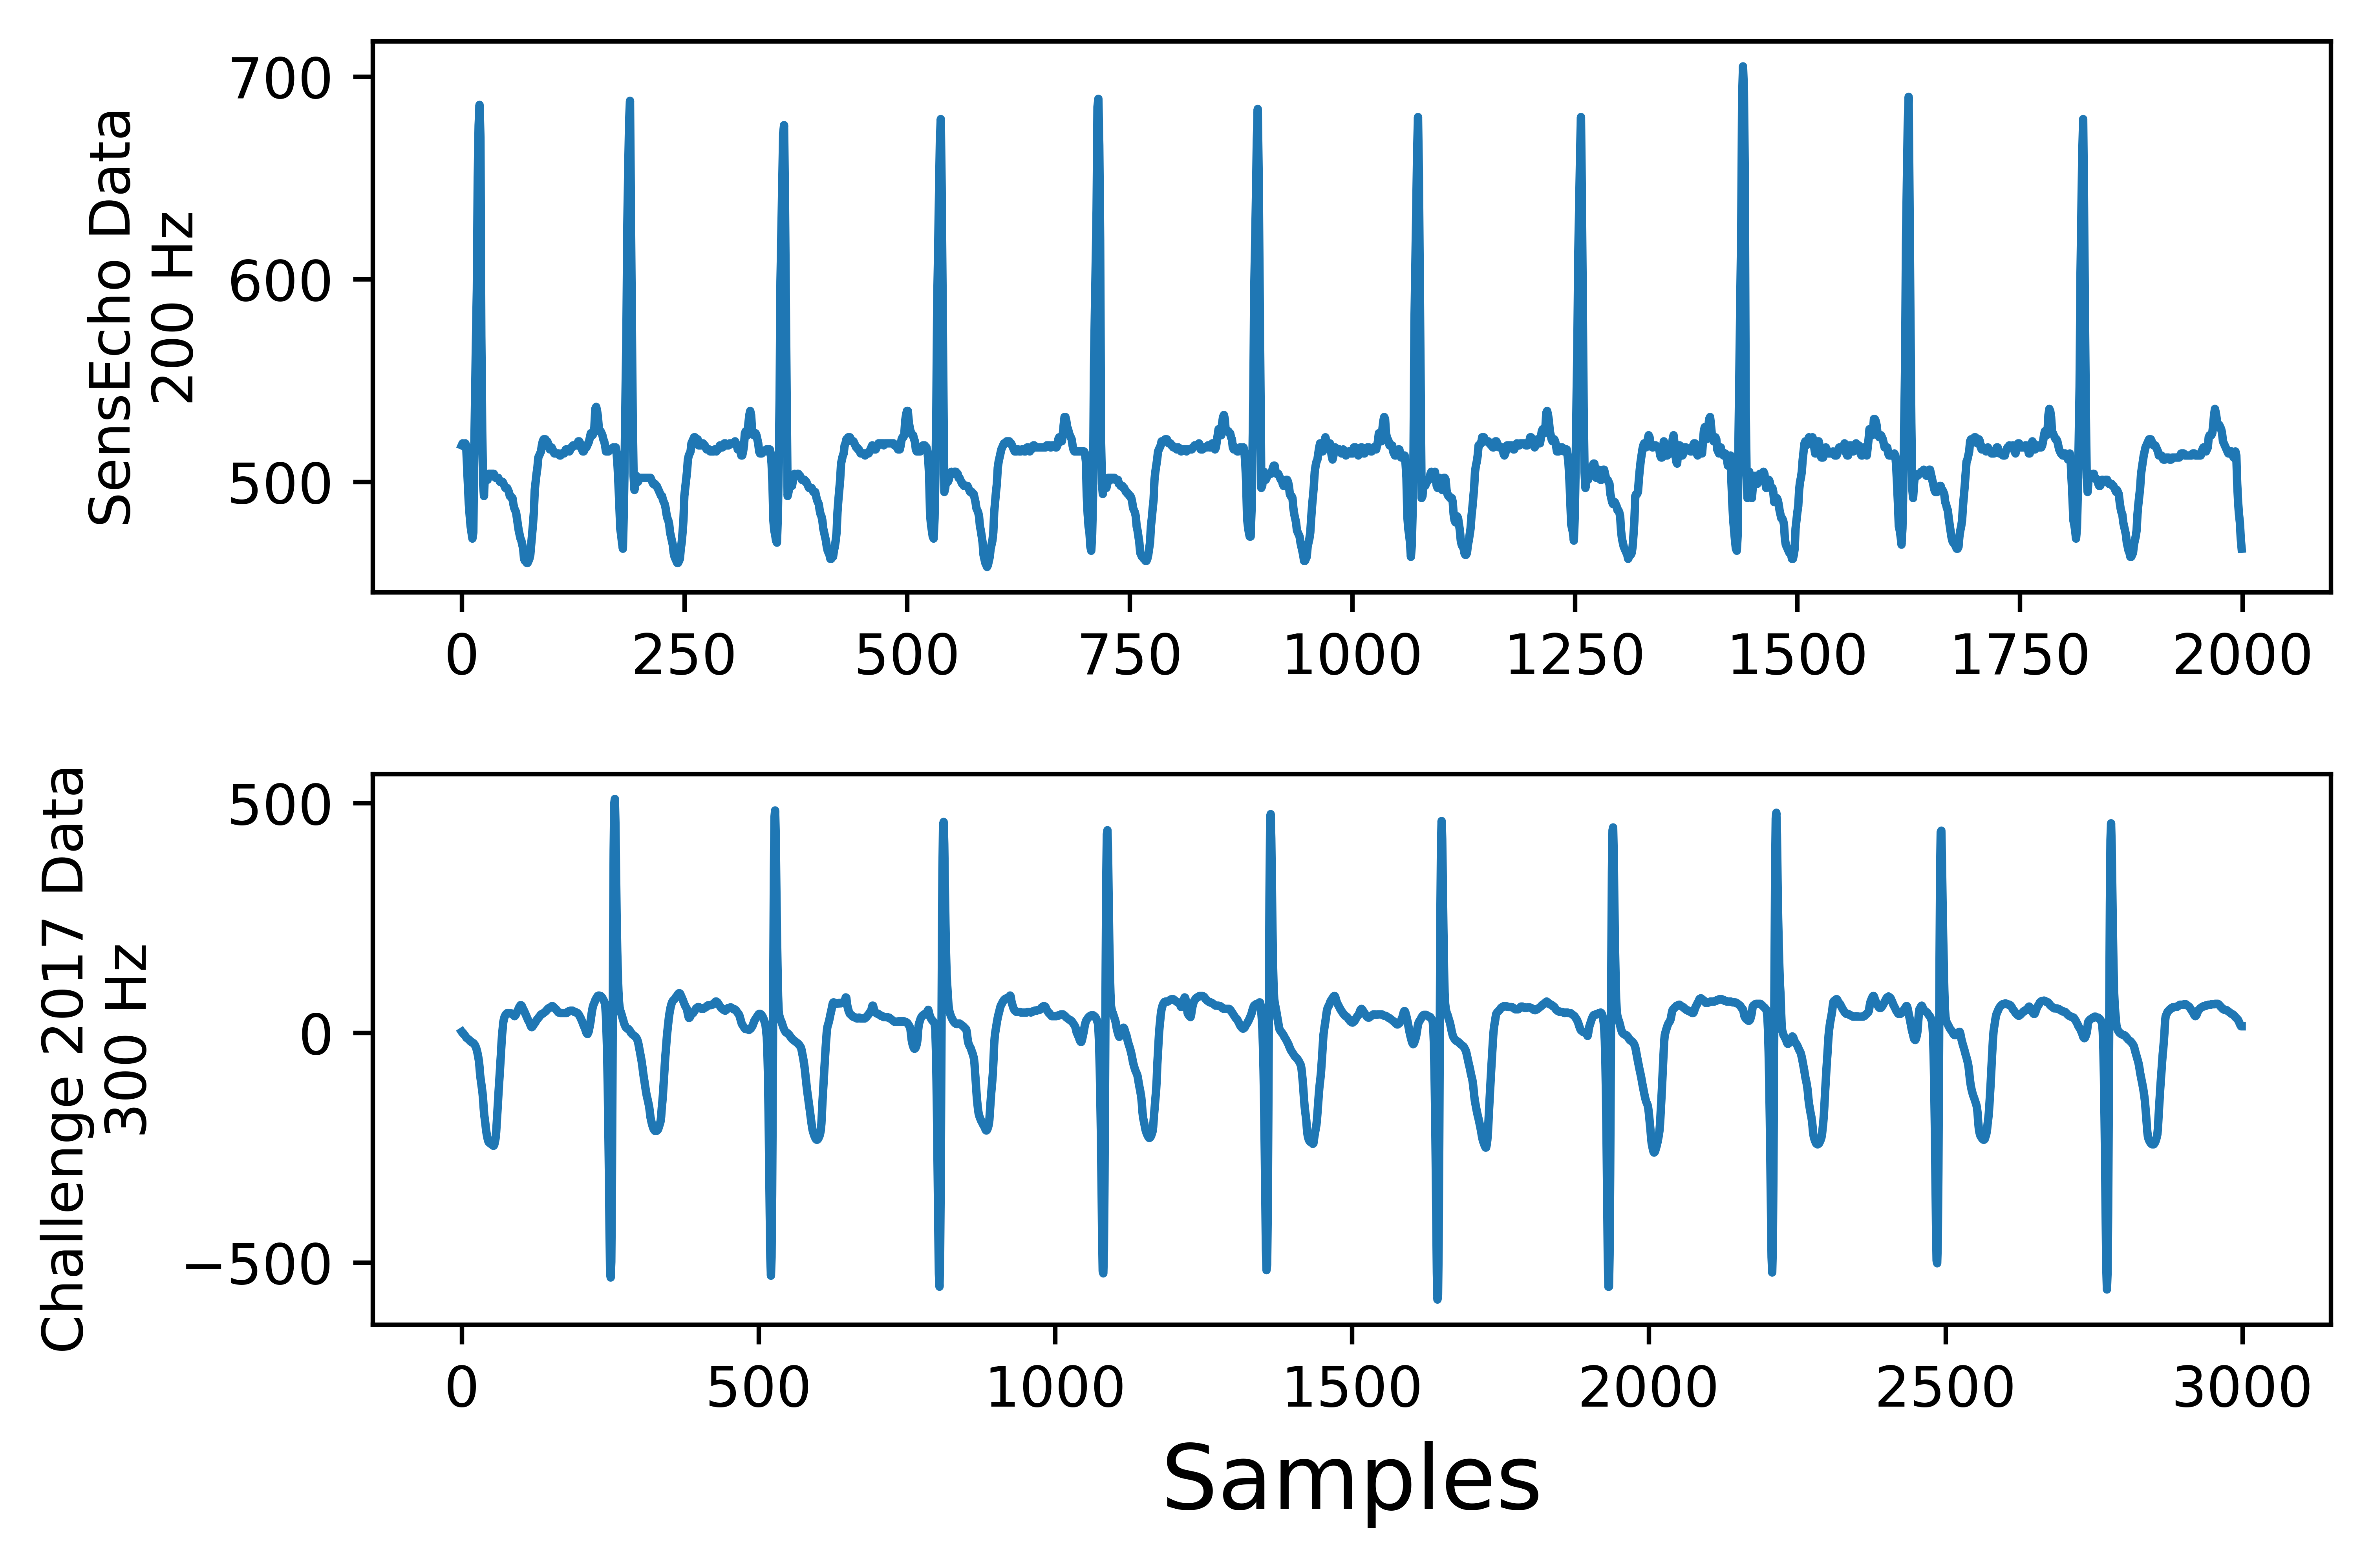

In [142]:
fig, axes = plt.subplots(2, 1, dpi=1024) 
ax0, ax1 = axes.ravel()
#plt.subplot(2,1,1)
ax0.plot(ecg[26000:28000])
#plt.subplot(2,1,2)
ax0.set_ylabel("SensEcho Data\n 200 Hz", fontsize=10)
ax1.plot(Physionetdata[3000:6000])
ax1.set_ylabel("Challenge 2017 Data \n 300 Hz",fontsize=10)
ax1.set_xlabel("Samples", fontsize=16)

#plt.xlabel=("fffff")
plt.tight_layout()
plt.savefig("Signallllll")
plt.show()
#plt.xlabel